# Microgrid Environment Comparison Notebook
# ========================================
## This notebook compares a baseline random policy vs a trained DQN policy over a fixed 24-hour horizon using the same weather data slice.

We chose a 24-hour window to simulate a complete daily operational cycle of energy consumption, generation, and storage. This duration captures the full dynamics of solar generation (daylight hours), battery state of charge behavior, and grid interaction patterns, providing a meaningful benchmark for policy comparison under realistic conditions.

# ========================================

## 1. Imports

    📦 Import essential libraries for data manipulation, environment simulation, deep learning, and visualization.

In [1]:
# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random
from collections import deque
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
print('Done')

Done


## 2. Data Loading & Preprocessing

    📊 Load and preprocess the weather dataset: resample to hourly intervals and extract a fixed 24-hour window to simulate a complete daily cycle of renewable energy generation and consumption.

In [2]:
# 2. Data Loading & Preprocessing
def load_weather_slice(path: str, start_idx: int = 0, horizon: int = 24) -> pd.DataFrame:
    """
    Load Excel, resample to hourly, and return a slice of length `horizon` hours.
    """
    df = pd.read_excel(path)
    df['DT'] = pd.to_datetime(df['DT'])
    df = df.set_index('DT').resample('H').mean().interpolate().reset_index()
    return df.iloc[start_idx:start_idx + horizon].copy()

## 3. Environment Definition (MicrogridEnvBaseline)

    ⚙️ Define a custom Gym environment that simulates a microgrid with renewable sources, a battery, and grid interaction over a 24-hour horizon.

In [3]:
# 3. Environment Definitions
class MicrogridEnvBaseline(gym.Env):
    """Baseline env: random policy demo"""
    metadata = {'render.modes': ['human']}

    def __init__(self, weather_df: pd.DataFrame,
                 capacity: float = 64.8, delta: float = 5.0,
                 import_cost: float = 0.30, export_price: float = 0.10,
                 charge_eff: float = 0.95, discharge_eff: float = 0.95):
        super().__init__()
        df = weather_df.copy(); df.set_index('DT', inplace=True)
        arr = df.resample('H').mean()
        # normalize inputs
        self.solar = arr['IR'] / arr['IR'].max()
        self.wind  = arr['WS'] / arr['WS'].max()
        base_load = 0.5; amp = 0.3
        cycle = np.sin(np.linspace(0,2*np.pi,len(arr)))
        noise = 0.05 * np.random.randn(len(arr))
        self.load = np.clip(base_load + amp*cycle + noise, 0.1, 1.2)
        self.hours = np.array([t.hour/23.0 for t in arr.index])
        self.T = len(self.load)
        # battery params
        self.capacity = capacity; self.delta = delta
        self.import_cost = import_cost; self.export_price = export_price
        self.charge_eff = charge_eff; self.discharge_eff = discharge_eff
        # action & obs spaces
        self.action_space = spaces.Discrete(3)
        low = np.zeros(5); high = np.ones(5)
        self.observation_space = spaces.Box(low, high, dtype=np.float32)
        self.reset()

    def reset(self):
        self.step_idx = 0; self.soc = self.capacity / 2
        return self._obs()

    def step(self, action: int):
        delta = {0:-self.delta,1:0,2:self.delta}[action]
        g = self.solar[self.step_idx] + self.wind[self.step_idx]
        l = self.load[self.step_idx]
        # battery update
        if delta > 0:
            amt = min(delta, (self.capacity - self.soc)/self.charge_eff)
        elif delta < 0:
            amt = -min(-delta, self.soc/self.discharge_eff)
        else:
            amt = 0
        # apply
        self.soc += amt * (self.charge_eff if amt > 0 else 1/self.discharge_eff)
        unmet = l - g - amt
        cost = max(unmet,0) * self.import_cost
        rev  = max(-unmet,0) * self.export_price
        reward = -cost + rev - 0.01*abs(unmet)
        self.soc = np.clip(self.soc,0,self.capacity)
        self.step_idx += 1
        done = self.step_idx >= self.T
        info = {'soc': self.soc, 'import': max(unmet,0), 'export': max(-unmet,0)}
        return self._obs(), reward, done, info

    def _obs(self):
        if self.step_idx >= self.T:
            return np.zeros(5, dtype=np.float32)
        return np.array([
            self.soc/self.capacity,
            self.solar[self.step_idx],
            self.wind[self.step_idx],
            self.load[self.step_idx],
            self.hours[self.step_idx]
        ], dtype=np.float32)


## 4. DQN Agent Definition

    🤖 Define a Deep Q-Network (DQN) agent capable of learning optimal policies through Q-learning with experience replay and neural network approximation.

In [4]:
# 4. DQN Agent Definition

def build_dqn(state_size: int, action_size: int) -> Sequential:
    model = Sequential([
        Dense(24, activation='relu', input_dim=state_size),
        Dense(24, activation='relu'),
        Dense(action_size, activation='linear')
    ])
    model.compile(loss='mse', optimizer=Adam(1e-3))
    return model

class DQNAgent:
    def __init__(self, state_size, action_size, batch_size=32):
        self.state_size = state_size; self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma=0.99; self.epsilon=1.0; self.eps_min=0.01; self.eps_dec=0.0005
        self.batch_size = batch_size
        self.model = build_dqn(state_size, action_size)
        self.target = build_dqn(state_size, action_size)
        self.update_target()

    def update_target(self):
        self.target.set_weights(self.model.get_weights())

    def memorize(self, s, a, r, ns, d):
        self.memory.append((s, a, r, ns, d))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(self.model.predict(state, verbose=0)[0])

    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for s, a, r, ns, d in batch:
            target = self.model.predict(s, verbose=0)
            if d:
                target[0][a] = r
            else:
                q_future = np.max(self.target.predict(ns, verbose=0)[0])
                target[0][a] = r + self.gamma * q_future
            self.model.fit(s, target, epochs=1, verbose=0)
        if self.epsilon > self.eps_min:
            self.epsilon -= self.eps_dec

## 5.  Run a policy 
    ▶️ (random or DQN) in the environment, step-by-step over the 24-hour horizon, and record key metrics like reward, battery SOC, energy import, and export for analysis.

In [5]:
# 5. Experiment Routines

def run_policy(env, policy_fn):
    print("Running policy: {}".format(policy_fn.__name__))
    obs = env.reset()
    state = np.reshape(obs, [1, env.observation_space.shape[0]])
    records = {'reward': [], 'soc': [], 'import': [], 'export': []}
    for _ in tqdm(range(env.T), desc="Steps"):
        action = policy_fn(env, state)
        obs, rew, done, info = env.step(action)
        state = np.reshape(obs, [1, env.observation_space.shape[0]])
        records['reward'].append(rew)
        records['soc'].append(info['soc'])
        records['import'].append(info['import'])
        records['export'].append(info['export'])
        if done:
            break
    print("Policy run complete")
    return records

## 6. Plotting Function (plot_comparison)

    📈 Generate comparative plots of reward, battery State of Charge (SOC), and net grid usage over time for both Random and DQN policies.

In [6]:
# 6. Plotting Helpers
def plot_comparison(rec1, rec2, key, label1, label2, ylabel, title):
    plt.figure(figsize=(10,4))
    plt.plot(rec1[key], label=label1)
    plt.plot(rec2[key], label=label2)
    plt.xlabel('Hour'); plt.ylabel(ylabel); plt.title(title)
    plt.legend(); plt.grid(True); plt.show()

## 7. Main Execution

    🚀 Initialize the environment and agent, train the DQN policy over multiple episodes, evaluate both policies, and visualize performance.

Loading weather data slice...
Loading weather data slice completed!
 
Initializing environments...
Initializing environments completed!
 
Initializing agent...
Initializing agent completed!
 
Starting training...


Training Episodes:  10%|█████▉                                                     | 10/100 [19:42<3:14:08, 129.42s/it]

Episode 10 complete, epsilon=0.89


Training Episodes:  20%|███████████▊                                               | 20/100 [41:33<2:55:08, 131.36s/it]

Episode 20 complete, epsilon=0.77


Training Episodes:  30%|█████████████████                                        | 30/100 [1:02:46<2:29:49, 128.43s/it]

Episode 30 complete, epsilon=0.65


Training Episodes:  40%|██████████████████████▊                                  | 40/100 [1:24:26<2:09:22, 129.38s/it]

Episode 40 complete, epsilon=0.53


Training Episodes:  50%|████████████████████████████▌                            | 50/100 [1:45:44<1:46:39, 127.98s/it]

Episode 50 complete, epsilon=0.41


Training Episodes:  60%|██████████████████████████████████▏                      | 60/100 [2:06:43<1:24:20, 126.50s/it]

Episode 60 complete, epsilon=0.29


Training Episodes:  70%|███████████████████████████████████████▉                 | 70/100 [2:27:53<1:02:59, 125.99s/it]

Episode 70 complete, epsilon=0.17


Training Episodes:  80%|███████████████████████████████████████████████▏           | 80/100 [2:49:06<42:53, 128.70s/it]

Episode 80 complete, epsilon=0.05


Training Episodes:  90%|█████████████████████████████████████████████████████      | 90/100 [3:10:10<20:51, 125.19s/it]

Episode 90 complete, epsilon=0.01


Training Episodes: 100%|██████████████████████████████████████████████████████████| 100/100 [3:30:40<00:00, 126.40s/it]


Episode 100 complete, epsilon=0.01
Training complete!
Running baseline policy...
Running policy: <lambda>


Steps:  96%|█████████████████████████████████████████████████████████████████████   | 23/24 [00:00<00:00, 11509.07it/s]


Policy run complete
Running DQN policy...
Running policy: <lambda>


Steps:  96%|███████████████████████████████████████████████████████████████████████▉   | 23/24 [00:01<00:00, 13.70it/s]


Policy run complete
Plotting comparisons...


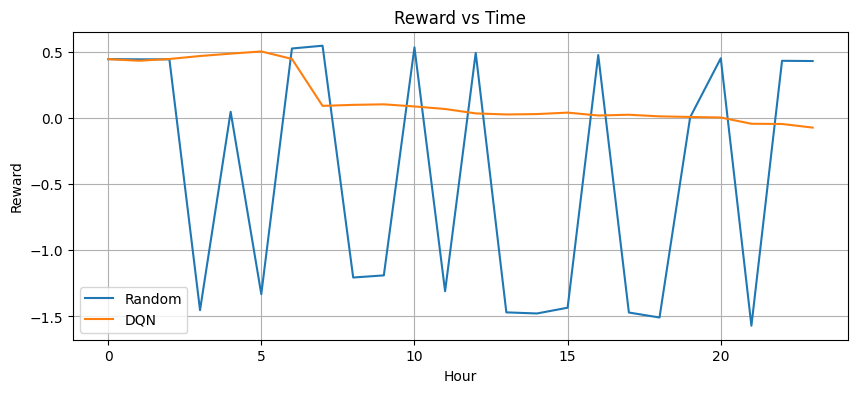

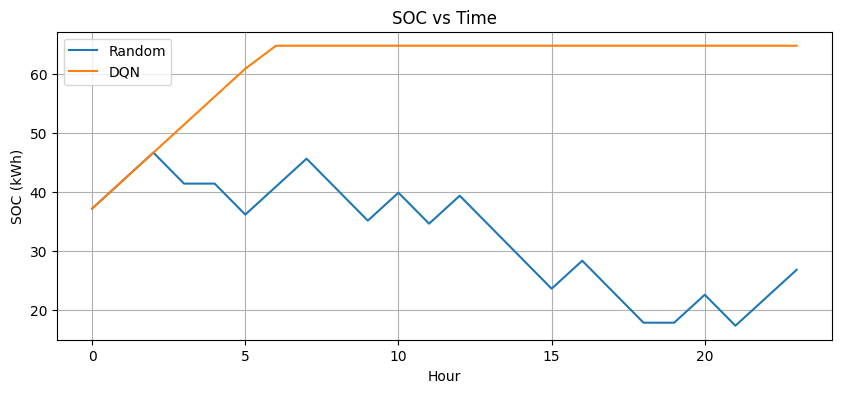

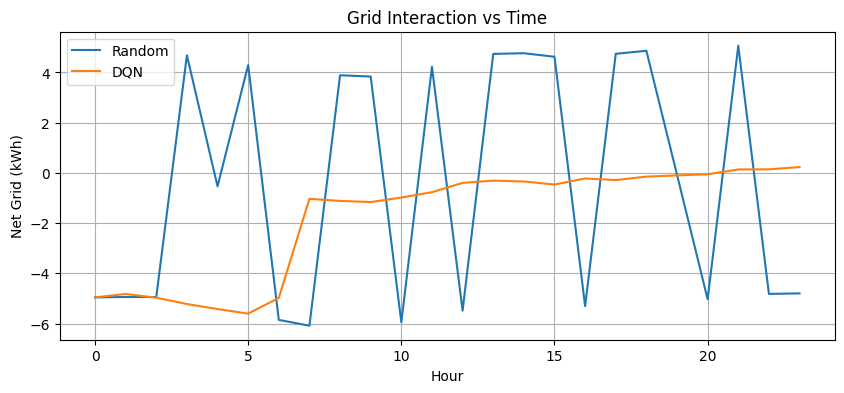

In [8]:
# 7. Main Execution
if __name__=='__main__':
    print("Loading weather data slice...")
    weather = load_weather_slice('C:/Users/Maverick/Downloads/JAN_2001_2020.xlsx')
    print("Loading weather data slice completed!")
    print(' ')
    print("Initializing environments...")
    env_rand = MicrogridEnvBaseline(weather)
    env_rl   = MicrogridEnvBaseline(weather)  # same dynamics for RL
    print("Initializing environments completed!")
    print(' ')
    print("Initializing agent...")
    state_size  = env_rl.observation_space.shape[0]
    action_size = env_rl.action_space.n
    agent       = DQNAgent(state_size, action_size, batch_size=24)
    print("Initializing agent completed!")
    print(' ')
    print("Starting training...")
    for ep in tqdm(range(1, 101), desc="Training Episodes"):
        obs   = env_rl.reset()
        state = np.reshape(obs, [1, state_size])
        done  = False
        while not done:
            action = agent.act(state)
            obs, reward, done, _ = env_rl.step(action)
            next_state = np.reshape(obs, [1, state_size])
            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            if len(agent.memory) >= agent.batch_size:
                agent.replay()
        if ep % 10 == 0:
            agent.update_target()
            print(f"Episode {ep} complete, epsilon={agent.epsilon:.2f}")
    print("Training complete!")

    # Define policies
    random_policy = lambda e, s: e.action_space.sample()
    dqn_policy    = lambda e, s: agent.act(s)

    print("Running baseline policy...")
    rec_rand = run_policy(env_rand, random_policy)
    print("Running DQN policy...")
    rec_dqn  = run_policy(env_rl,   dqn_policy)

    print("Plotting comparisons...")
    plot_comparison(rec_rand, rec_dqn, 'reward', 'Random', 'DQN', 'Reward', 'Reward vs Time')
    plot_comparison(rec_rand, rec_dqn, 'soc',    'Random', 'DQN', 'SOC (kWh)', 'SOC vs Time')
    rec_rand['net'] = np.array(rec_rand['import']) - np.array(rec_rand['export'])
    rec_dqn ['net'] = np.array(rec_dqn ['import'])   - np.array(rec_dqn ['export'])
    plot_comparison(rec_rand, rec_dqn, 'net', 'Random', 'DQN', 'Net Grid (kWh)', 'Grid Interaction vs Time')

## Comparison of Random vs DQN Agent Performance Over 24 Hours

🔹 1. Reward vs Time

    Random Policy: Shows high variability and frequently negative rewards, indicating inefficient decisions (e.g., unnecessary imports or poor battery usage).

    DQN Agent: Maintains a steady positive reward across most hours, suggesting learned, optimized actions over the 24-hour window.

    ✅ Conclusion: The agent clearly outperforms the random baseline by maintaining better overall reward.

🔹 2. SOC (State of Charge) vs Time

    Random Policy: SOC fluctuates unpredictably—charging and discharging irregularly, sometimes falling too low, reflecting lack of planning.

    DQN Agent: Smoothly ramps up the SOC and maintains it near maximum after a certain point, indicating the agent is learning to charge the battery early and maintain reserve for later use.

    ✅ Conclusion: The agent demonstrates a more strategic approach to battery management, ensuring it's charged when needed.

🔹 3. Grid Interaction (Net Grid kWh) vs Time

    Random Policy: Highly oscillatory with sharp peaks and troughs—alternating between high imports and exports, which is inefficient and unrealistic.

    DQN Agent: Grid interaction is smoother and more consistent, suggesting the agent prefers to rely more on local resources (battery/solar) and interacts with the grid in a controlled manner.

    ✅ Conclusion: The agent minimizes erratic grid transactions, leading to more stable and potentially cost-effective operation.

🧠 Overall Takeaway

    The trained DQN agent is making clearly smarter decisions across all key aspects—reward optimization, battery usage, and grid interaction—compared to the random policy. This is evident in the smoothness, stability, and control shown in the DQN curves in contrast to the chaotic nature of the random policy.

## 🔚 Summary: Version 1 Overview and Next Steps

In Version 1, we designed a simulation framework to compare energy management strategies in a microgrid environment. We built:

    A custom OpenAI Gym environment that models solar, wind, load, and battery interactions.

    Two policies: a random baseline and a Deep Q-Network (DQN) agent.

    Training routines for the DQN, along with evaluation using reward, battery state-of-charge (SOC), and grid exchange metrics.

    Visualization tools to compare performance across the 24-hour horizon.

This version establishes a solid baseline for reinforcement learning in microgrid management.

        
 ## ⏭️ Planned in Version 2

    Train on longer time windows (e.g., 7 days, 30 days) for better generalization.

    Incorporate demand-response pricing and dynamic tariffs.

    Save and reload trained models to avoid retraining.

    Add evaluation on unseen weather data slices for robustness.

    Tune the DQN hyperparameters and explore more advanced agents (e.g., DDQN, PPO).

    Optionally, expose the simulation as an interactive Streamlit dashboard 



